In [ ]:
from google.colab import drive
import os
from PIL import Image, ImageDraw, ImageFont,ImageOps
from PIL.Image import open
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
path_to_zip = '/content/drive/My\ Drive/fast_ai/datasets/379764_737475_bundle_archive.zip'

In [ ]:
! unzip -q {path_to_zip}

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
lists = os.listdir('/content/images/')
lists[:10]

['2099_2001.jpg',
 '12133_2005.jpg',
 '37584_2012.jpg',
 '48080_2014.jpg',
 '44564_2013.jpg',
 '53808_2016.jpg',
 '12522_2005.jpg',
 '44876_2014.jpg',
 '876_2000.jpg',
 '32158_2010.jpg']

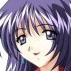

In [ ]:
image = cv2.imread('/content/images/2099_2001.jpg')
cv2_imshow(image)
#print (image is not None)

In [ ]:
path_color = Path('/content/images')
path_gray = Path('/content/gray')


In [ ]:
class grayscaleConv(object):
  def __init__(self, path_gray, path_color):
    self.path_gray = path_gray
    self.path_color = path_color

  def __call__(self, fn, i):
    dest = self.path_gray/fn.relative_to(self.path_color)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    img = ImageOps.grayscale(img)
    img.save(dest)

In [ ]:
imgl = ImageList.from_folder(path_color)

In [ ]:
parallel(grayscaleConv(path_gray, path_color), imgl.items)

In [ ]:
bs, size = 64, 120
arch = models.resnet34

In [ ]:
src = ImageImageList.from_folder(path_gray).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs, size):
  data = (src.label_from_func(lambda x: path_color/x.name)
  .transform(get_transforms(max_zoom=1.1), size=size, tfm_y=True)
  .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

  data.c = 3
  return data

In [ ]:
data_gen = get_data(bs, size)

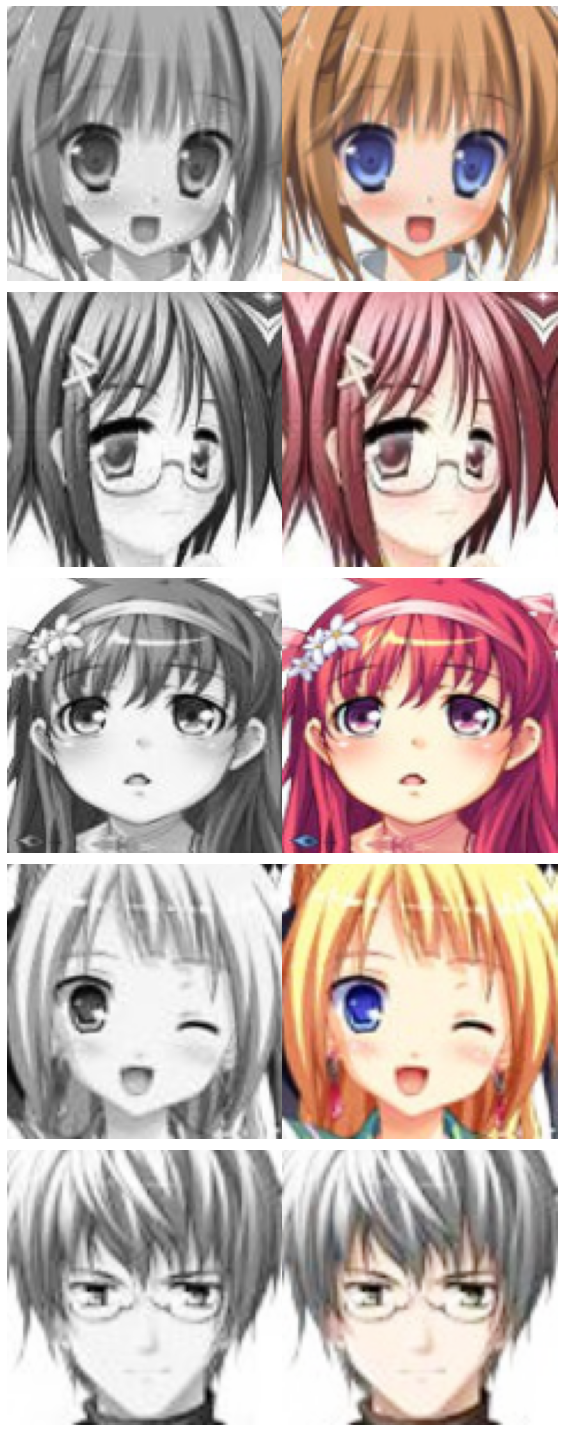

In [ ]:
data_gen.show_batch(5)

In [ ]:
wd = 1e-3

In [ ]:
y_range = (-3., 3.)

In [ ]:
loss_gen = MSELossFlat()

In [ ]:
def create_gen_learner():
  return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.128058,0.129811,12:18
1,0.120466,0.118385,12:04


In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.120211,0.117286,12:43
1,0.114196,0.113109,12:43
2,0.112799,0.111093,12:44


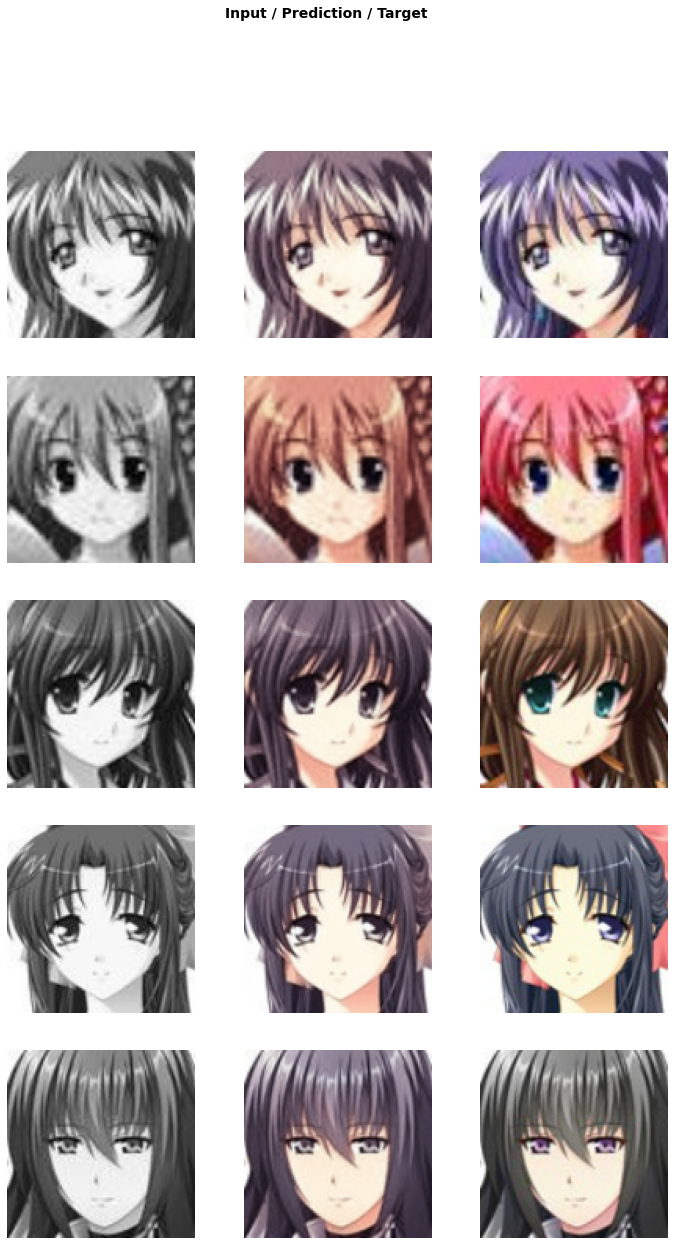

In [ ]:
learn_gen.show_results(2)

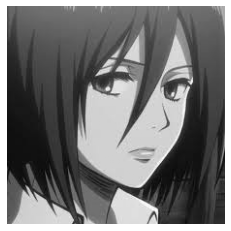

In [ ]:
test_img = open_image('/content/mikasa.jpg')
test_img.show(figsize=(4,4))

In [ ]:
pred = learn_gen.predict(test_img)

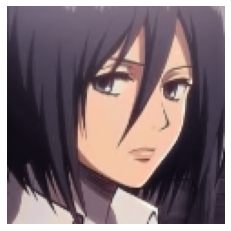

In [ ]:
show_image(pred[0], figsize=(4,4))

In [ ]:
learn_gen.path = Path('/content')

In [ ]:
learn_gen.path

PosixPath('/content')

In [ ]:
learn_gen.save('gen-2')

In [ ]:
learn_gen.export('color-using-unet.pkl')